In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path

import pytorch_lightning as pl
import yaml
from torch.utils.data import DataLoader
from transformers import set_seed

from datasets.class_writer import CSVWriter
from datasets.class_dataset import CSVDataset
from models.deberta_model import PretrainedDeBertaNER
from utils.metrics import Statistics
from utils.log_reader import TensorBoardReader

set_seed(42)

In [3]:
# Config initialisation
data_config = yaml.load(open("configs/multi_data_config.yaml", 'r'), Loader=yaml.Loader)
model_config = yaml.load(open("configs/deberta_model_config.yaml", 'r'), Loader=yaml.Loader)

In [4]:
# Data processing
val_dataset = CSVDataset(data_config["validate_data_path"],
                         is_uncased=data_config["is_uncased"],
                         pretrained_tokenizer=data_config["pretrained_tokenizer_path"],
                         max_length=data_config["max_token_number"])
val_dataloader = DataLoader(val_dataset, shuffle=False,
                            batch_size=data_config["batch_size"], drop_last=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# Getting path to the last checkpoint
t_reader = TensorBoardReader(Path(model_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = t_reader.get_ckpt_path()

In [6]:
# Pytorch lightning
deberta_model = PretrainedDeBertaNER.load_from_checkpoint(path_to_checkpoint)
print(deberta_model)
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(deberta_model, val_dataloader)

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'deberta.embeddings.word_embeddings._weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeque

PretrainedDeBertaNER(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(250102, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropout):

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5870070457458496
       test_recall          0.44975343346595764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5870070457458496, 'test_recall': 0.44975343346595764}]

                     precision    recall  f1-score   support

              Human       0.84      0.80      0.82      8521
             M-BART       0.53      0.70      0.60       417
           M-BART50       0.45      0.50      0.47      1986
            M2M-100       0.28      0.35      0.31      1803
            OPUS-MT       0.35      0.40      0.37      2014
          mT5-Large       0.33      0.26      0.29       810
          mT5-Small       0.61      0.44      0.51       490
       ruGPT2-Large       0.79      0.50      0.61       395
       ruGPT3-Large       0.48      0.53      0.50      1644
      ruGPT3-Medium       0.49      0.41      0.44      1170
       ruGPT3-Small       0.52      0.66      0.58      1154
          ruT5-Base       0.67      0.70      0.69       440
ruT5-Base-Multitask       0.41      0.18      0.25       370
         ruT5-Large       0.34      0.09      0.14       290

           accuracy                           0.59     21504
          macro avg   

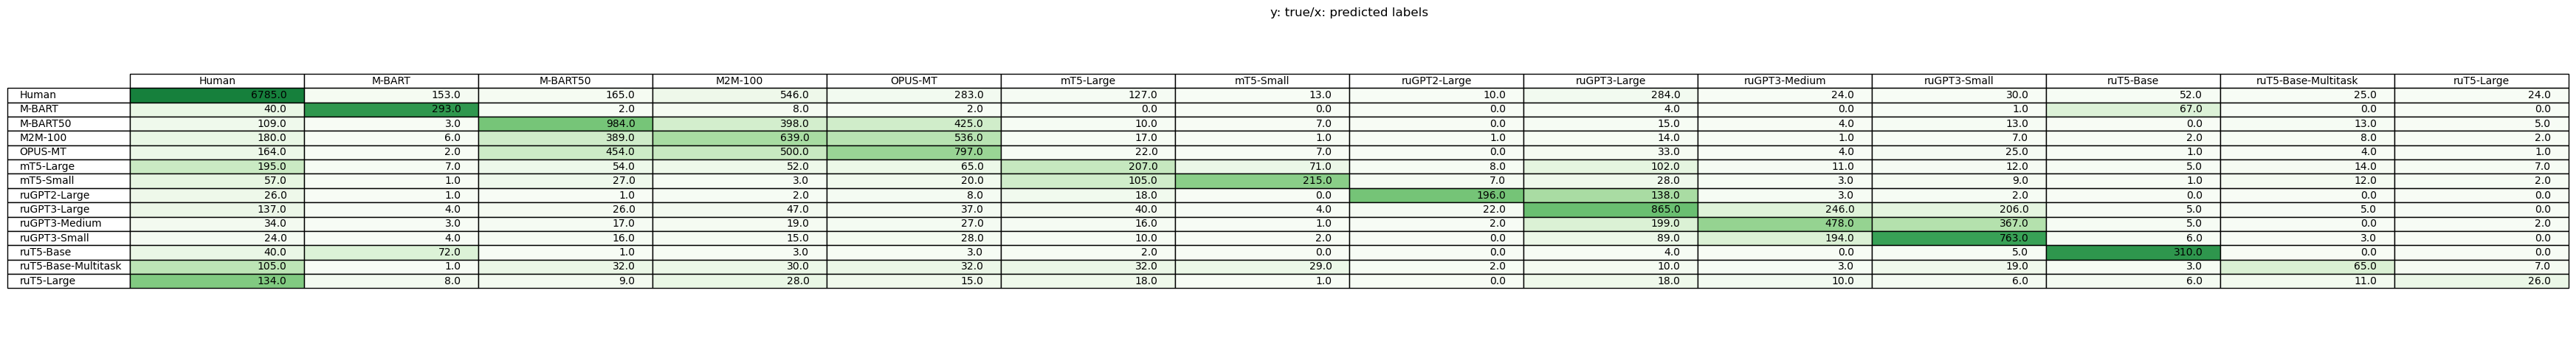

Wrongly predicted examples:
| Record id: | Sentence:                                                                                                                                        | True label:   | Pred labels: |
| 188201     | Где-где, где-то, подслеповато мигал в них огонек, утешая издали робкого путника.                                                                 | mT5-Large     | Human        |
| 18777      | - ANABIOZIS (от латинского ANABORIS, что означает «венец                                                                                         | ruGPT3-Medium | ruGPT3-Small |
| 107658     | Содействие патриотическому, духовному и нравственному воспитанию молодежи, поддержка талантливых молодых людей и социальные инициативы молодежи. | OPUS-MT       | M-BART50     |
| 51538      | Оперативный штаб по борьбе с терроризмом начинает функционировать.                                                                               | OPUS-MT       | M2M-100      |
| 89046

In [7]:
# Print metrics
stats = Statistics(deberta_model, val_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [8]:
# Processing test data
test_dataset = CSVDataset(data_config["test_data_path"],
                          is_uncased=data_config["is_uncased"],
                          without_labels=True,
                          pretrained_tokenizer=data_config["pretrained_tokenizer_path"],
                          max_length=data_config["max_token_number"])
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=data_config["batch_size"], drop_last=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
# Markup of test data
deberta_writer = CSVWriter(deberta_model, test_dataloader, val_dataloader.dataset.index2label)
deberta_writer.write(data_config["pred_data_path"])